In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Rescaling, Input, Embedding, Conv2D, MaxPooling2D, Flatten, Dropout, SimpleRNN, Bidirectional, LSTM

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import image_dataset_from_directory

# CNN For Mask Dataset

In [27]:
train_path = '/kaggle/input/facemask789/Face Mask Dataset/Train'
val_path = '/kaggle/input/facemask789/Face Mask Dataset/Validation'
test_path = '/kaggle/input/facemask789/Face Mask Dataset/Test'

In [28]:
mask_train = image_dataset_from_directory(
    train_path,
    image_size=(180, 180),
    shuffle=True,
    batch_size=32
)
mask_val = image_dataset_from_directory(
    val_path,
    image_size=(180, 180),
    shuffle=True,
    batch_size=32
)
mask_test = image_dataset_from_directory(
    test_path,
    image_size=(180, 180),
    shuffle=False,
    batch_size=32
)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [29]:
norm_layer = Rescaling(1./255)
mask_train = mask_train.map(lambda x, y: (norm_layer(x), y))
mask_val = mask_val.map(lambda x, y: (norm_layer(x), y))
mask_test = mask_test.map(lambda x, y: (norm_layer(x), y))

In [30]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
cnn_h = cnn.fit(
    mask_train,
    validation_data=(mask_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.8904 - loss: 0.2700 - val_accuracy: 0.9862 - val_loss: 0.0373
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9796 - loss: 0.0519 - val_accuracy: 0.9875 - val_loss: 0.0361
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9832 - loss: 0.0421 - val_accuracy: 0.9912 - val_loss: 0.0209
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9863 - loss: 0.0354 - val_accuracy: 0.9950 - val_loss: 0.0172
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9905 - loss: 0.0213 - val_accuracy: 0.9937 - val_loss: 0.0202


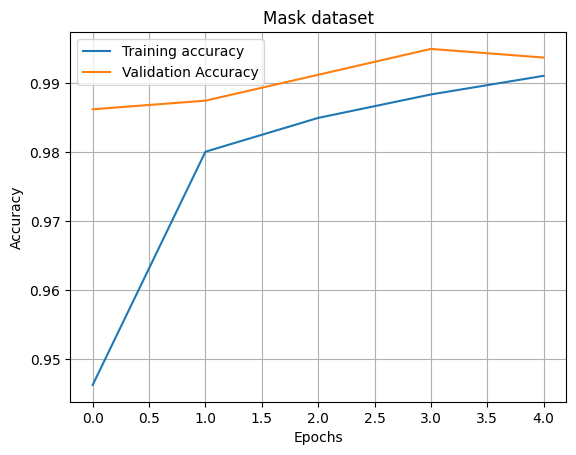

In [33]:
plt.plot(cnn_h.history['accuracy'], label='Training accuracy')
plt.plot(cnn_h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Mask dataset')
plt.legend()
plt.grid(True)
plt.show()

# LSTM for Sentiment analysis

In [34]:
rev = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
rev.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [35]:
rev['sentiment'] = rev['sentiment'].map({'positive': 1, 'negative': 0})

In [36]:
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
train_rev, val_rev = train_test_split(rev, test_size=0.2, stratify=rev['sentiment'], random_state=42)

In [38]:
def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

In [39]:
train_rev['clean'] = train_rev['review'].apply(clean_text)
val_rev['clean'] = val_rev['review'].apply(clean_text)

In [40]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [41]:
def lemm_text(text):
    tokens = word_tokenize(text)
    lemma = [lemm.lemmatize(w) for w in tokens]
    return " ".join(lemma)

In [42]:
train_rev['lemma'] = train_rev['clean'].apply(lemm_text)
val_rev['lemma'] = val_rev['clean'].apply(lemm_text)

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
vs = 20000
oov = '<OOV>'
ml = 200
tokenizer = Tokenizer(num_words=vs, oov_token=oov)
tokenizer.fit_on_texts(train_rev['lemma'])

In [45]:
train_seq = tokenizer.texts_to_sequences(train_rev['lemma'])
train_pad = pad_sequences(train_seq, maxlen=ml, padding='post')
val_seq = tokenizer.texts_to_sequences(val_rev['lemma'])
val_pad = pad_sequences(val_seq, maxlen=ml, padding='post')

In [46]:
lstm = Sequential([
    Embedding(vs, 128, input_length=ml),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# lstm_h = lstm.fit(
#     train_seq, train_rev['sentiment'].values,
#     validation_data=(val_seq, val_rev['sentiment'].values),
#     epochs=5, 
#     batch_size=128
# )

In [49]:
# plt.plot(lstm_h.history['accuracy'], label='Training accuracy')
# plt.plot(lstm_h.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Mask dataset')
# plt.legend()
# plt.grid(True)
# plt.show()

# RNN For Stock Prediction

In [50]:
stock = pd.read_csv('/kaggle/input/google-stock-prediction/GOOG.csv')
stock.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [53]:
stock['date'] = pd.to_datetime(stock['date'])
stock = stock.sort_values('date')
data = stock[['date', 'close']].copy()

In [54]:
from sklearn.preprocessing import MinMaxScaler

In [55]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(data['close'].values.reshape(-1, 1))

In [56]:
def create_seq(data, sl=60):
    x1, y1 = [], []
    for i in range(sl, len(data)):
        x1.append(data[i-sl:i,0])
        y1.append(data[i, 0])
    return np.array(x1), np.array(y1)

In [57]:
x1, y1 = create_seq(prices)

In [58]:
x1 = np.reshape(x1, (x1.shape[0], x1.shape[1], 1))

In [59]:
n = x1.shape[0]
ts = int(n*0.7)
vs = int(n*0.2)

x1_train, y1_train = x1[:ts], y1[:ts]
x1_val, y1_val = x1[ts:ts+vs], y1[ts:ts+vs]
x1_test, y1_test = x1[ts+vs:], y1[ts+vs:]

In [60]:
rnn = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(60,1)),
    SimpleRNN(50, return_sequences=True),
    SimpleRNN(50),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
rnn.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [62]:
rnn_h = rnn.fit(
    x1_train, y1_train,
    validation_data=(x1_val, y1_val),
    epochs=20, batch_size=32 
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.2079 - mae: 0.2079 - val_loss: 0.0969 - val_mae: 0.0969
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0278 - val_mae: 0.0278
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0514 - mae: 0.0514 - val_loss: 0.1077 - val_mae: 0.1077
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0977 - val_mae: 0.0977
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.05

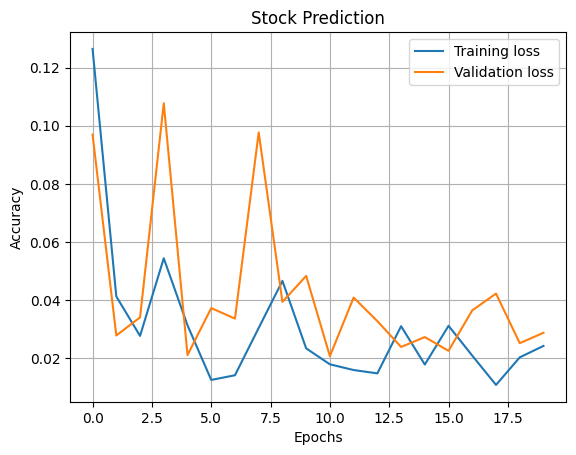

In [63]:
plt.plot(rnn_h.history['loss'], label='Training loss')
plt.plot(rnn_h.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Stock Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Language Translation using encoder decoder

In [117]:
sen = pd.read_csv('/kaggle/input/hin-english/hin.txt', sep='\t', usecols=[0,1], header=None, names=['english', 'hindi'])
sen.head()

,english,hindi
0,Wow!,वाह!
1,Duck!,झुको!
2,Duck!,बतख़!
3,Help!,बचाओ!
4,Jump.,उछलो.


In [118]:
def preprocess_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

In [119]:
sen['english'] = sen['english'].apply(preprocess_text)
sen['hindi'] = sen['hindi'].apply(lambda x: '<start>' + str(x) + '<end>')

In [120]:
train, temp = train_test_split(sen, test_size=0.2, random_state=42)
test, val = train_test_split(temp, test_size=0.5, random_state=42)

In [121]:
eng_tok = Tokenizer(filters='')
eng_tok.fit_on_texts(train['english'])
ivs = len(eng_tok.word_index) + 1

hin_tok = Tokenizer(filters='')
hin_tok.fit_on_texts(train['hindi'])
tvs = len(hin_tok.word_index) + 1

In [122]:
x_all = eng_tok.texts_to_sequences(sen['english'])
mli = max(len(s) for s in x_all)

y_all = hin_tok.texts_to_sequences(sen['hindi'])
mlt = max(len(s) for s in y_all)

In [123]:
def token_data(tokenizer, data, column, max_len):
    seq = tokenizer.texts_to_sequences(data[column])
    return pad_sequences(seq, maxlen=max_len, padding='post')

In [124]:
x_train = token_data(eng_tok, train, 'english', mli)
x_val = token_data(eng_tok, val, 'english', mli)
x_test = token_data(eng_tok, test, 'english', mli)
y_train = token_data(hin_tok, train, 'hindi', mlt)
y_val = token_data(hin_tok, val, 'hindi', mlt)
y_test = token_data(hin_tok, test, 'hindi', mlt)

In [125]:
y_train_in = y_train[:, :-1]
y_val_in = y_val[:, :-1]
y_test_in = y_test[:, :-1]

In [126]:
y_train_out = y_train[:, 1:]
y_val_out = y_val[:, 1:]
y_test_out = y_test[:, 1:]

In [127]:
def build_lstm(ivs, tvs, mli, mlt, emb_dim, units):
    enc_inputs = Input(shape=(mli,))
    enc_emb = Embedding(ivs, emb_dim, mask_zero=True)(enc_inputs)
    enc_cell = LSTM(units, return_sequences=False, return_state=True)
    _, state_h, state_c = enc_cell(enc_emb)
    enc_states = [state_h, state_c]

    dec_inputs = Input(shape=(mlt-1,))
    dec_emb = Embedding(tvs, emb_dim, mask_zero=True)(dec_inputs)
    dec_cell = LSTM(units, return_sequences=True, return_state=True)
    dec_output, _, _ = dec_cell(dec_emb, initial_state=enc_states)

    dec_dense = Dense(tvs, activation='softmax')
    dec_outputs = dec_dense(dec_output)

    model = Model([enc_inputs, dec_inputs], dec_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [128]:
lstm_enc = build_lstm(ivs, tvs, mli, mlt, 256, 256)

In [129]:
lstm_enc_h = lstm_enc.fit(
    [x_train, y_train_in], y_train_out,
    validation_data=([x_val, y_val_in], y_val_out),
    epochs=20, batch_size=64
)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5320 - loss: 7.5431 - val_accuracy: 0.7682 - val_loss: 5.5646
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7216 - loss: 5.8193 - val_accuracy: 0.7703 - val_loss: 5.2886
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7244 - loss: 5.5179 - val_accuracy: 0.7656 - val_loss: 5.1497
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6818 - loss: 5.2940 - val_accuracy: 0.0578 - val_loss: 5.0578
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0611 - loss: 5.1591 - val_accuracy: 0.0568 - val_loss: 5.0085
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0634 - loss: 5.0706 - val_accuracy: 0.0604 - val_loss: 4.9764
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0678 - loss: 4.9516 - val_accuracy: 0.0617 - val_loss: 4.9292
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0698 - loss: 4.8464 - val_accuracy: 0.0629 - v

In [136]:
def build_gru(ivs, tvs, mli, mlt, emb_dim, units):
    enc_inputs = Input(shape=(mli,))
    enc_emb = Embedding(ivs, emb_dim, mask_zero=True)(enc_inputs)
    gre = GRUCell(units)
    enc_cell = RNN(gre, return_sequences=False, return_state=True)
    _, enc_state = enc_cell(enc_emb)

    dec_inputs = Input(shape=(mlt-1,))
    dec_emb = Embedding(tvs, emb_dim, mask_zero=True)(dec_inputs)
    grd = GRUCell(units)
    dec_cell = RNN(grd, return_sequences=True, return_state=True)
    dec_output, _ = dec_cell(dec_emb, initial_state=[enc_state])

    dec_dense = Dense(tvs, activation='softmax')
    dec_outputs = dec_dense(dec_output)

    model = Model([enc_inputs, dec_inputs], dec_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [137]:
gru_enc = build_gru(ivs, tvs, mli, mlt, 256, 256)

In [138]:
gru_enc_h = gru_enc.fit(
    [x_train, y_train_in], y_train_out,
    validation_data=([x_val, y_val_in], y_val_out),
    epochs=20, batch_size=64
)

Epoch 1/20


W0000 00:00:1762367329.895646     631 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4692 - loss: 7.6535

W0000 00:00:1762367332.742508     628 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4736 - loss: 7.6378

W0000 00:00:1762367335.559843     631 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1762367336.298933     628 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.4777 - loss: 7.6228 - val_accuracy: 0.7682 - val_loss: 5.8248
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7225 - loss: 6.0762 - val_accuracy: 0.7682 - val_loss: 5.5094
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7224 - loss: 5.7309 - val_accuracy: 0.7712 - val_loss: 5.2148
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7281 - loss: 5.4141 - val_accuracy: 0.7737 - val_loss: 5.0807
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7348 - loss: 5.1510 - val_accuracy: 0.7721 - val_loss: 4.9536
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7459 - loss: 4.9053 - val_accuracy: 0.7727 - val_loss: 4.8328
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7479 - loss: 4.6644 - val_accuracy: 0.7805 - val_loss: 4.7699
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7533 - loss: 4.4293 - val_accuracy: 0.7024 - val_loss: 

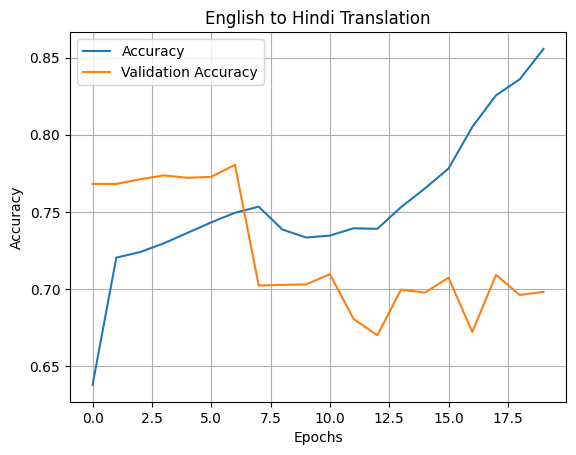

In [139]:
plt.plot(gru_enc_h.history['accuracy'], label='Accuracy')
plt.plot(gru_enc_h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('English to Hindi Translation')
plt.grid(True)
plt.legend()
plt.show()

# AutoEncoder

In [140]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import UpSampling2D

In [141]:
def nrm(x):
    x = x.astype('float32')/255.0
    return x

In [142]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train[:5000]
x_test = x_test[:5000//5]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [143]:
x_train = nrm(x_train)
x_test = nrm(x_test)

In [148]:
def build_encoder(input_shape=(32, 32, 3)):
    inp = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = x

    decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    ae = Model(inp, decoded)
    ae.compile(optimizer='adam', loss='mse')
    return ae
    

In [149]:
ae = build_encoder()

In [150]:
ae_h = ae.fit(
    x_train, x_train,
    epochs=20, 
    batch_size=64,
    validation_data=(x_test, x_test)
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0406 - val_loss: 0.0128
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0064
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_l